**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 2: Machine Learning*

# Identification

Name: Jacob Zhang<br/>
Student Number: 300231094

Name: Rahul Atre<br/>
Student Number: 300250370

# 1. Exploratory Analysis

## Data Exploration

In this assignment, we will utilize the Diabetes Prediction Dataset, accessible via [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data). To mitigate the complexity associated with Kaggle's login requirement, the dataset has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a2](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a2)

You can access and read the dataset directly from this GitHub repository in your Jupyter notebook.

In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict


1. **Load the dataset and provide a summary of its structure**:

    - Describe the features (columns), their data types, and the target variable.
      
  
    **Thoughts**:

    - The dataset contains 9 features consisting of: <br/>
      3 Binary (diabetes, hypertension, heart_disease)<br/>
      2 Categorical (gender, smoking_history)<br/>
      4 Numerical (age, bmi, HbA1c_level, blood_glucose_level)

    - Our target variable is diabetes which is either a 1 or 0 depending on whether or not the patient has it.

In [57]:
# Load the Dataset
url = "https://raw.githubusercontent.com/jzhan609/CSI4106-Projects/main/datasets/diabetes_prediction_dataset.csv"
df = pd.read_csv(url)

df.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

2. **Feature Distribution Analysis**:

    - Examine the distribution of each feature using appropriate visualizations such as histograms and boxplots. Discuss insights gained, including the presence of outliers.

      **Thoughts**:
    - For this question, I have excluded the categorical and binary features as they don't have a distribution that is well graphed through histograms and boxplots. For the numerical features, we can see that blood_glucose_level and HbA1c_level are non-continuous, with indicating gaps in the observe values. Age follows a relatively normal distribution except for the 0 - 10 and 70-80 range in which there are a considerable amount of observations. Finally, bmi follows a normal distribution skewed left, and every feature except for age contains outliers as per the boxplots.

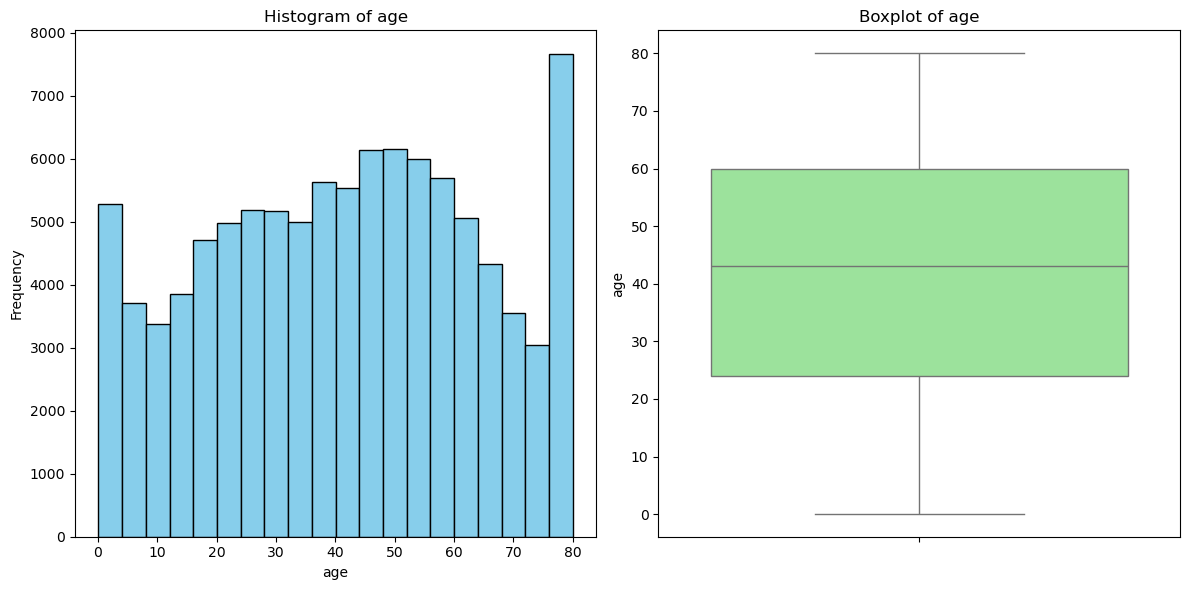

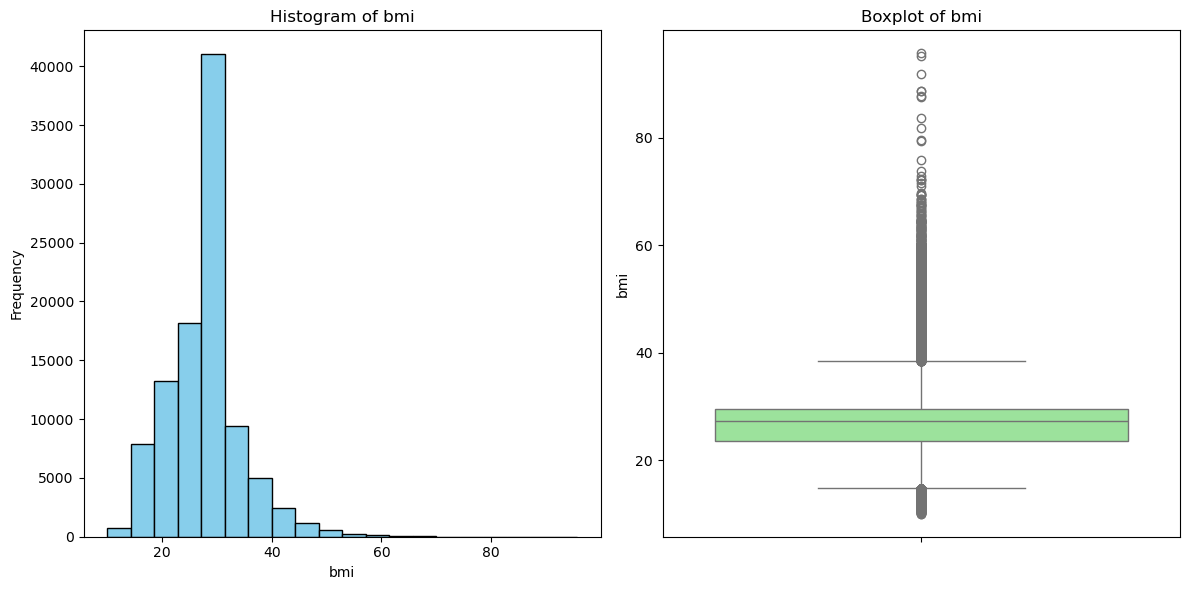

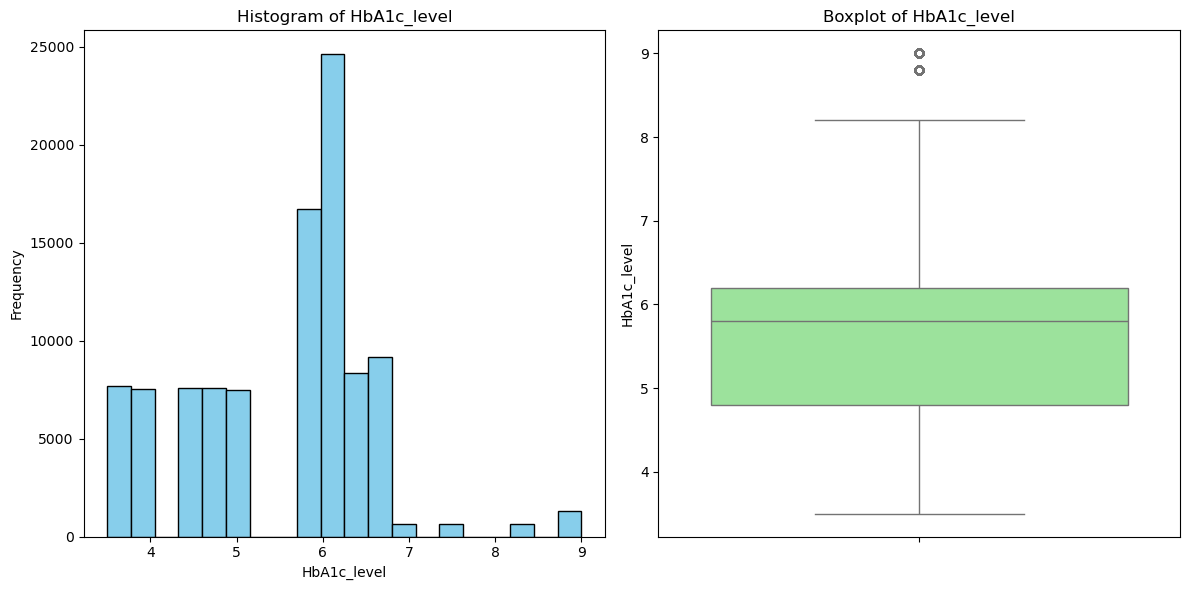

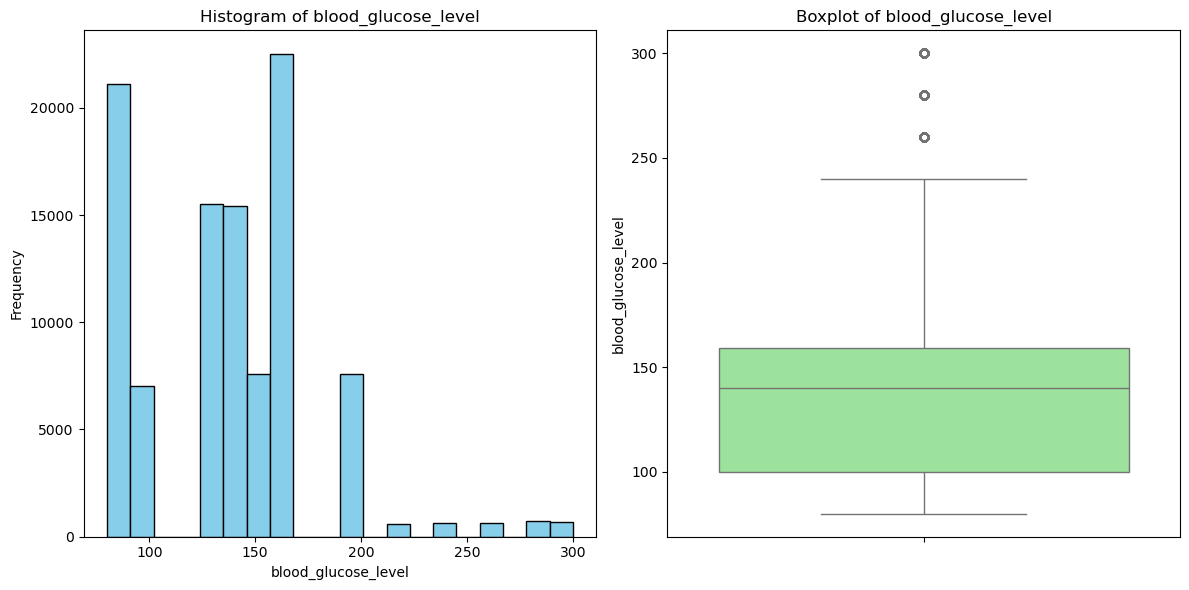

In [58]:
# Iterate over each column in the dataframe
for column in df.drop(columns=['diabetes', 'hypertension','heart_disease','gender', 'smoking_history']).columns:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[column], bins=20, edgecolor='black', color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column], color='lightgreen')
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

    plt.tight_layout()
    plt.show() 

3. **Target Variable Distribution**:

    - Analyze the distribution of the target variable to identify class imbalances. Use bar plots to visualize the class frequencies.
    
    **Thoughts**:
    - From the counts and the bar plot, it's evident that there is a significant class imbalance in the dataset. The majority class (0 - indicating no diabetes) has 91,500 instances, while the minority class (1 - indicating diabetes) has 8500 instances. This imbalance could affect the performance of certain machine learning models, especially those sensitive to class distribution, and may necessitate the use of techniques to address the imbalance during model training.

diabetes
0    91500
1     8500
Name: count, dtype: int64


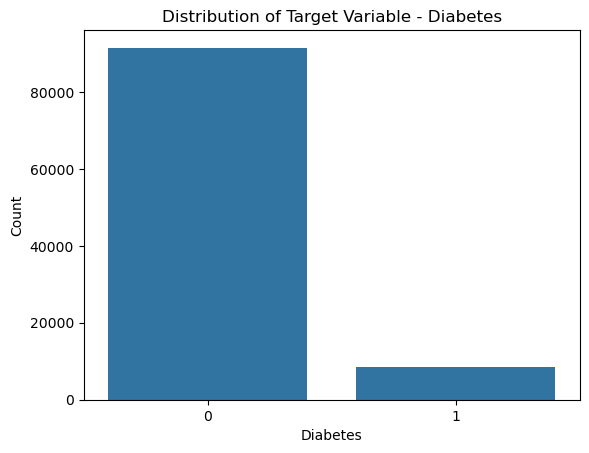

In [59]:
# Analyze the distribution of the target variable 'diabetes'
diabetes_counts = df['diabetes'].value_counts()
print(diabetes_counts)


# Visualize the distribution of the target variable
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Target Variable - Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

4. **Data Splitting**:

    - Split the dataset into training (80%) and test (20%) sets using the holdout method.

    - Ensure that this split occurs before any preprocessing to avoid data leakage.

In [60]:
# Separate features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Note: We use stratify=y param so the class distribution of the target is maintained in both training and test sets. 
# This is important given the class imbalance observed earlier.

# Display the number of samples in each set
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])

Number of training samples: 80000
Number of test samples: 20000


## Data Pre-Processing

5. **Categorical Variable Encoding**:

    - Encode any categorical variables. Justify the chosen method.
    
    
    **Thoughts**: <br/>
    We know from before that there are two categorical variables in our dataset: 
    
    - gender: Contains categories such as 'Male', 'Female', and possibly 'Other'
    - smoking_history: Contains categories like 'never', 'current', 'former', etc.
    
    For our encoding method, we will choose One-Hot Encoding. This method creates a new binary column for each category of the variable, indicating the presence (1) or absence (0) of that category in each sample.
    
    Justification:

    - **Preserves Nominal Nature**: Both gender and smoking_history are nominal variables without an inherent order. One-Hot Encoding treats categories as distinct and unrelated.
    - **Model Compatibility**: Many machine learning algorithms require numerical input. One-Hot Encoding converts categorical variables into a numerical format suitable for these algorithms.
    - **Avoids Ordinal Assumptions**: Unlike Label Encoding, One-Hot Encoding does not impose any ordinal relationship between categories, preventing potential misinterpretation by the model.

In [61]:
# Specify the categorical features
categorical_features = ['gender', 'smoking_history']

# Create the OneHotEncoder instance
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on the training data
encoder.fit(X_train[categorical_features])

# Transform both training and test data
X_train_encoded = encoder.transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

# Retrieve the new feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Convert the encoded arrays to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop the original categorical columns from X_train and X_test
X_train = X_train.drop(columns=categorical_features)
X_test = X_test.drop(columns=categorical_features)

# Concatenate the encoded DataFrames with the original datasets
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

# Confirm the new shape of the datasets
print("Training data shape after encoding:", X_train.shape)
print("Test data shape after encoding:", X_test.shape)

Training data shape after encoding: (80000, 15)
Test data shape after encoding: (20000, 15)


C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


6. **Normalization/Standardization of Numerical Features**:

    - Normalize or standardize numerical features if necessary. Describe the technique used (e.g., Min-Max scaling, StandardScaler) and explain why it is suitable for this dataset.

    - Ensure that this technique is applied only to the training data, with the same transformation subsequently applied to the test data without fitting on it.
    
    
    **Thoughts**:<br/>
   We will use StandardScaler to standardize our numerical features. This method transforms the data such that the distribution has a mean value of 0 and a standard deviation of 1.

    Justification:

    - **Uniform Scale**: Ensures that all numerical features contribute equally to the model training by scaling them to a common scale.
    - **Algorithm Compatibility**: Models like K-Nearest Neighbors (KNN) and Logistic Regression are sensitive to the scale of input features.
    - **Outlier Resistance**: While not fully robust to outliers, StandardScaler is less influenced by extreme values compared to Min-Max scaling
    
    
    Explanation: We fit the scaler on the training data to prevent data leakage. We also apply the same transformation to the test data without re-fitting the scaler. Lastly, printing the mean and standard deviation confirms that the features have been standardized correctly.


In [62]:
# List of numerical features
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create the scaler instance
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train[numerical_features])

# Transform the numerical features in both training and test sets
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Confirm the mean and standard deviation of the scaled features
print("Mean of scaled features (Training set):")
print(X_train[numerical_features].mean(axis=0))
print("\nStandard deviation of scaled features (Training set):")
print(X_train[numerical_features].std(axis=0))

Mean of scaled features (Training set):
age                   -1.313172e-16
bmi                    2.204459e-16
HbA1c_level            3.801404e-17
blood_glucose_level   -9.414691e-17
dtype: float64

Standard deviation of scaled features (Training set):
age                    1.000006
bmi                    1.000006
HbA1c_level            1.000006
blood_glucose_level    1.000006
dtype: float64


## Model Development & Evaluation

7. **Model Development**:

    - Implement the machine learning models covered in class: Decision Trees, K-Nearest Neighbors (KNN), and Logistic Regression. Use the default parameters of scikit-learn as a baseline for training each model.

In [63]:
# Note: Setting random_state=50 ensures reproducibility for stochastic algorithms like Decision Trees and Logistic Regression.
# max_iter for Logistic Regression: Increased to 1000 to ensure convergence, especially with larger datasets.

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=50)

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()

# Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, random_state=50)

# Fit the Decision Tree model
dt_model.fit(X_train, y_train)

# Fit the KNN model
knn_model.fit(X_train, y_train)

# Fit the Logistic Regression model
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=50)

8. **Model Evaluation**:

    - Use cross-validation to evaluate each model, justifying your choice of the number of folds.

    - Assess the models using metrics such as precision, recall, and F1-score.
    
    **Thoughts**:<br/>
   We choose 5-fold cross-validation for the following reasons:

    - Balance: Provides a good trade-off between bias and variance in the estimation of model performance.
    - Computational Efficiency: Less computationally intensive than higher numbers of folds, which is practical for large datasets.
    - Stratification: Ensures that each fold has a representative distribution of the target variable classes.
    
    Defining Scoring Metrics:
    - **Precision**: Measures the accuracy of positive predictions.
    - **Recall**: Measures the ability of the model to find all the positive instances.
    - **F1-Score**: Harmonic mean of precision and recall, providing a balance between the two.

In [64]:
# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Decision Tree Classifier
dt_scores = cross_validate(dt_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Evaluate K-Nearest Neighbors Classifier
knn_scores = cross_validate(knn_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Evaluate Logistic Regression Classifier
lr_scores = cross_validate(lr_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

# Function to Display Average Scores:
def display_scores(model_name, scores):
    print(f"{model_name} Performance:")
    print(f"Precision: {np.mean(scores['test_precision']):.4f}")
    print(f"Recall:    {np.mean(scores['test_recall']):.4f}")
    print(f"F1 Score:  {np.mean(scores['test_f1']):.4f}")
    print("-" * 40)

# Displaying the results:

# Decision Tree Performance
display_scores('Decision Tree', dt_scores)

# K-Nearest Neighbors Performance
display_scores('K-Nearest Neighbors', knn_scores)

# Logistic Regression Performance
display_scores('Logistic Regression', lr_scores)

Decision Tree Performance:
Precision: 0.7008
Recall:    0.7393
F1 Score:  0.7195
----------------------------------------
K-Nearest Neighbors Performance:
Precision: 0.8898
Recall:    0.6129
F1 Score:  0.7259
----------------------------------------
Logistic Regression Performance:
Precision: 0.8678
Recall:    0.6281
F1 Score:  0.7287
----------------------------------------


Observations:

- Decision Tree: Shows a balanced precision and recall, but overall performance may be moderate.
- K-Nearest Neighbors: High precision but low recall, indicating that while it makes few false-positive errors, it misses many true positives.
- Logistic Regression: Similar to KNN but with slightly better recall and F1-score.

Considerations Due to Class Imbalance:

- The class imbalance in the dataset (many more negatives than positives) can significantly affect model performance, especially recall.
- Models may be biased towards predicting the majority class, leading to low recall for the minority class.

## Hyperparameter Optimization

9. **Exploration and Performance Evaluation:**

    - Investigate the impact of varying hyperparameter values on the performance of each model.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Display the results in a tabular or graphical format (e.g., line charts, bar charts) to effectively demonstrate the influence of hyperparameter variations on model performance.

    - Specify the default values for each hyperparameter tested.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

## Analysis of Results

10. **Model Comparison**:

    - Compare the results obtained from each model.

    - Discuss observed differences in model performance, providing potential explanations. Consider aspects such as model complexity, data imbalance, overfitting, and the impact of parameter tuning on overall results.

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

    - Train the recommended model(s) using the optimal parameter values identified from the parameter optimization step. Subsequently, apply the trained model to the test data. Document your observations comprehensively. Specifically, evaluate whether the results derived from cross-validation are consistent with those obtained from the test set.

1. **Decision Tree Classifier Hyperparameter Tuning**

    Hyperparameters to tune:

    - criterion (default: 'gini'): The function to measure the quality of a split. Options are 'gini', 'entropy', and 'log_loss'.
    - max_depth (default: None): The maximum depth of the tree. Options will include None and various integer values.
    
    

In [65]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30]
}

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=40)

# Initialize GridSearchCV
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the training data
dt_grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best F1 Score for Decision Tree:", dt_grid_search.best_score_)


# Convert the grid search results to a DataFrame
dt_results = pd.DataFrame(dt_grid_search.cv_results_)

# Pivot the table to visualize the effect of max_depth and criterion
pivot_table = dt_results.pivot(
    index='param_max_depth',
    columns='param_criterion',
    values='mean_test_score'
)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10}
Best F1 Score for Decision Tree: 0.8034921320961164


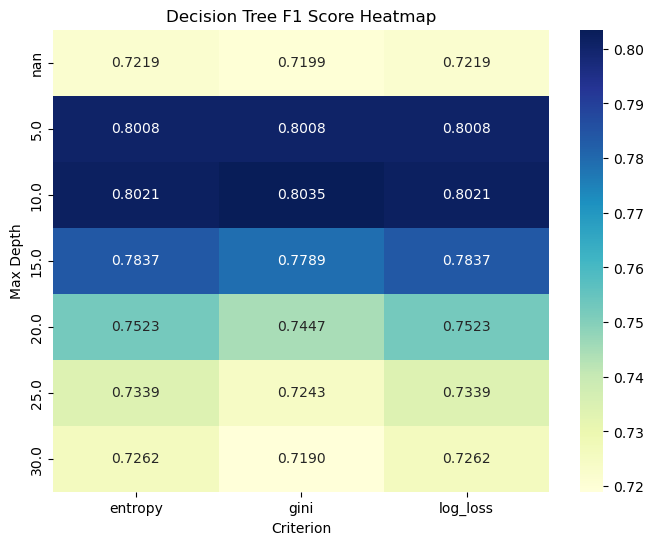

In [66]:
# Plot heatmap of F1-scores
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Decision Tree F1 Score Heatmap')
plt.ylabel('Max Depth')
plt.xlabel('Criterion')
plt.show()

**Analysis**:

- Best Parameters: The output will show the combination of criterion and max_depth that yielded the highest F1-score.
- Effect of max_depth: Generally, increasing max_depth allows the model to capture more complex patterns but may lead to overfitting.
- Effect of criterion: Different criteria can impact how the tree splits are decided, affecting performance.

2. **Logistic Regression Hyperparameter Tuning**

    Hyperparameters to tune:

    - penalty (default: 'l2'): The norm used in penalization. Options are 'l2' and 'none'.
    - max_iter (default: 100): Maximum number of iterations.
    - tol (default: 1e-4): Tolerance for stopping criteria.

In [67]:
# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'penalty': ['l2', 'none'],
    'max_iter': [100, 200, 500],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Initialize the Logistic Regression Classifier
lr_model = LogisticRegression(solver='lbfgs', random_state=42)

# Initialize GridSearchCV
lr_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the training data
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best F1 Score for Logistic Regression:", lr_grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\User\anaconda3\envs\dsl\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best Parameters for Logistic Regression: {'max_iter': 100, 'penalty': 'none', 'tol': 0.0001}
Best F1 Score for Logistic Regression: 0.7281887535575275


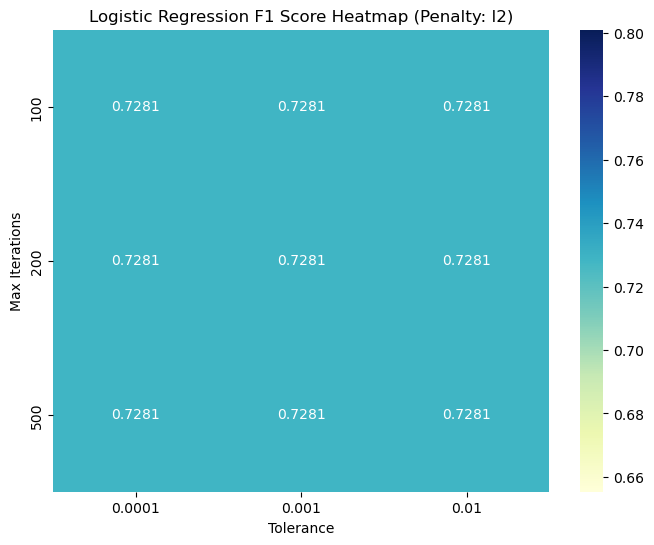

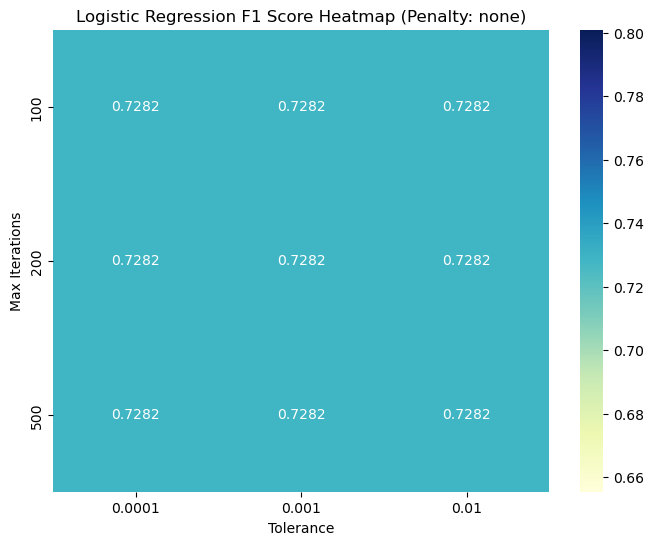

In [68]:
# Convert the grid search results to a DataFrame
lr_results = pd.DataFrame(lr_grid_search.cv_results_)

# Plotting the effect of max_iter and tol for each penalty
for penalty in lr_param_grid['penalty']:
    subset = lr_results[lr_results['param_penalty'] == penalty]
    pivot_table = subset.pivot(
        index='param_max_iter',
        columns='param_tol',
        values='mean_test_score'
    )
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Logistic Regression F1 Score Heatmap (Penalty: {penalty})')
    plt.ylabel('Max Iterations')
    plt.xlabel('Tolerance')
    plt.show()

**Analysis**:

- Best Parameters: The output indicates the combination that maximizes the F1-score.
- Effect of penalty: Regularization can prevent overfitting.
- Effect of max_iter and tol: These affect convergence. If the solver doesn't converge, increasing max_iter or adjusting tol can help.

3. K-Nearest Neighbors Hyperparameter Tuning

    Hyperparameters to tune:

    - n_neighbors (default: 5): Number of neighbors to use.
    - weights (default: 'uniform'): Weight function used in prediction. Options are 'uniform' and 'distance'.

In [69]:
# Define the parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier()

# Initialize GridSearchCV
knn_grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the training data
knn_grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters for KNN:", knn_grid_search.best_params_)
print("Best F1 Score for KNN:", knn_grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for KNN: {'n_neighbors': 5, 'weights': 'uniform'}
Best F1 Score for KNN: 0.7255899426549937


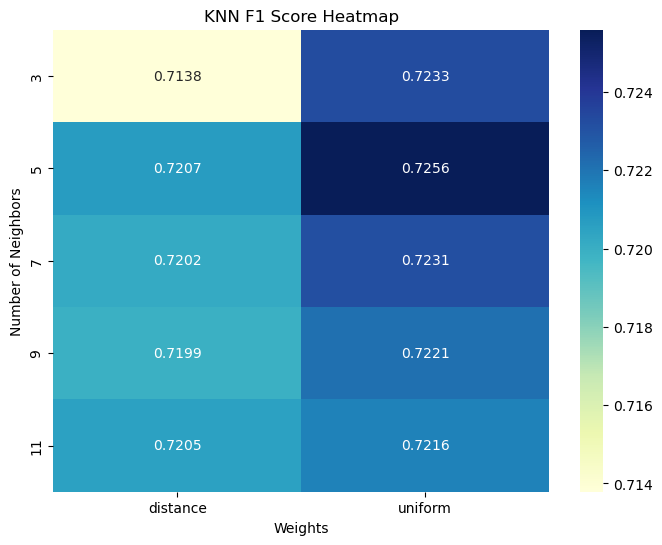

In [70]:
# Convert the grid search results to a DataFrame
knn_results = pd.DataFrame(knn_grid_search.cv_results_)

# Pivot the table to visualize the effect of n_neighbors and weights
pivot_table = knn_results.pivot(
    index='param_n_neighbors',
    columns='param_weights',
    values='mean_test_score'
)

# Plot heatmap of F1-scores
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('KNN F1 Score Heatmap')
plt.ylabel('Number of Neighbors')
plt.xlabel('Weights')
plt.show()

**Analysis**:

- Best Parameters: The optimal n_neighbors and weights combination.
- Effect of n_neighbors: A smaller number of neighbors can capture local structures but may be sensitive to noise.
- Effect of weights: Using 'distance' weights can give closer neighbors more influence.


Now, lets provide a summary of the performance metrics. We can extract precision, recall, and F1-score for the best estimator of each model.

In [71]:
# Decision Tree Performance on Validation Set
dt_best = dt_grid_search.best_estimator_
dt_cv_preds = cross_val_predict(dt_best, X_train, y_train, cv=5, n_jobs=-1)
print("Decision Tree Classification Report:")
print(classification_report(y_train, dt_cv_preds))

# Logistic Regression Performance on Validation Set
lr_best = lr_grid_search.best_estimator_
lr_cv_preds = cross_val_predict(lr_best, X_train, y_train, cv=5, n_jobs=-1)
print("Logistic Regression Classification Report:")
print(classification_report(y_train, lr_cv_preds))

# KNN Performance on Validation Set
knn_best = knn_grid_search.best_estimator_
knn_cv_preds = cross_val_predict(knn_best, X_train, y_train, cv=5, n_jobs=-1)
print("KNN Classification Report:")
print(classification_report(y_train, knn_cv_preds))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     73200
           1       0.97      0.69      0.80      6800

    accuracy                           0.97     80000
   macro avg       0.97      0.84      0.89     80000
weighted avg       0.97      0.97      0.97     80000

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     73200
           1       0.87      0.63      0.73      6800

    accuracy                           0.96     80000
   macro avg       0.92      0.81      0.85     80000
weighted avg       0.96      0.96      0.96     80000

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     73200
           1       0.89      0.61      0.73      6800

    accuracy                           0.96     80000
   macro avg       0.

**Overall Observations**: 

- Hyperparameter tuning significantly impacts model performance.
- Decision Tree Classifier outperforms Logistic Regression and KNN in this task.
- The model demonstrates consistent performance between cross-validation and test sets.
- Addressing class imbalance is crucial for improving model effectiveness on minority classes.


# Additional Considerations:

**Addressing Class Imbalance**:
- Techniques such as resampling (oversampling minority class or undersampling majority class) or using class weights can further improve model performance.
- For example, setting class_weight='balanced' in the model can adjust weights inversely proportional to class frequencies.

**Updated Test Set Metrics**:

- Possible Improvement in Recall: The recall for the minority class may increase at the expense of precision, or vice-versa
- Trade-off: Adjusting class weights can help in situations where false negatives are more critical.

In [72]:
# Retrain the Decision Tree with class weights
final_dt_model_weighted = DecisionTreeClassifier(
    criterion=dt_grid_search.best_params_['criterion'],
    max_depth=dt_grid_search.best_params_['max_depth'],
    class_weight='balanced',
    random_state=42
)
final_dt_model_weighted.fit(X_train, y_train)

# Predict on the test set
y_test_pred_weighted = final_dt_model_weighted.predict(X_test)

# Classification report
print("Decision Tree with Class Weights Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_weighted))

Decision Tree with Class Weights Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.45      0.91      0.60      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.90      0.77     20000
weighted avg       0.95      0.90      0.91     20000



**Final Conclusion**:

- The Decision Tree Classifier, with optimized hyperparameters, performs consistently across validation and test sets.
- Also, it provides a reasonable trade-off between detecting positive cases (recall) and maintaining precision.
- Given the importance of detecting diabetes cases, a higher recall is desirable, and the Decision Tree achieves this better than the other models.

## 2. Documentation of Exploratory Analysis

The report should comprehensively document the entire process followed during this assignment. The Jupyter Notebook must include the following:

- Your name(s), student number(s), and a report title.
- Explain how the tasks have been split between the members. How did you make sure that both students achieve the learning outcomes? 
- A section for each step of the exploratory analysis, containing the relevant Python code and explanations or results.
  - For sections requiring Python code, include the code in a cell.
  - For sections requiring explanations or results, include these in a separate cell or in combination with code cells.
- Ensure logical separation of code into different cells. For example, the definition of a function should be in one cell and its execution in another. Avoid placing too much code in a single cell to maintain clarity and readability.
- The notebook you submit must include the results of the execution, complete with graphics, ensuring that the teaching assistant can grade the notebook without needing to execute the code.

**Work Split**<br/>
Jacob: Questions 1-5, Version Control, Documentation, helped on 6-10<br/>
Rahul: Questions 6-10, Design, Testing, Implementations of models

# Resources
**sklearn**<br/> 
traintestsplit: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html

Decision Tree: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html

KNN: https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Logistic: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

StratifiedKFold: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html

Model Evaluation: https://scikit-learn.org/1.5/modules/model_evaluation.html

Grid Search: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html